In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import LabelEncoder
from nltk import word_tokenize

In [3]:
df=pd.read_csv('dataset.csv',usecols=['category','text'])
df.dropna()
print(df.shape)
df.head()

(2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [25]:
train_x,test_x,train_y,test_y=train_test_split(df['text'],df['category'],random_state=1)

le=LabelEncoder()
train_y=le.fit_transform(train_y)
test_y=le.fit_transform(test_y)
print(list(le.classes_))

['business', 'entertainment', 'politics', 'sport', 'tech']


In [5]:
tagged_data=[]
for i in tqdm(range(len(train_x))):
    tagged_data.append(TaggedDocument(word_tokenize(list(train_x)[i].lower()),[str(list(train_y)[i])]))

100%|██████████| 1668/1668 [00:07<00:00, 232.76it/s]


In [6]:
test_data=[]
for i in tqdm(range(len(test_x))):
    test_data.append(TaggedDocument(word_tokenize(list(test_x)[i].lower()),[str(list(test_y)[i])]))

100%|██████████| 557/557 [00:02<00:00, 239.46it/s]


In [7]:
model=Doc2Vec(dm=1,vector_size=100,alpha=0.025,min_alpha=0.001,min_count=2)
model.build_vocab([x for x in tagged_data])

model.train(tagged_data,epochs=10,total_examples=len(tagged_data))

In [8]:
model.save("d2v_model")

In [9]:
def genVector(model,dataset):
    target,vector=zip(*[(doc.tags[0],model.infer_vector(doc.words)) for doc in dataset])
    return target,vector

In [10]:
mod=Doc2Vec.load("d2v_model")
y_train,x_train=genVector(mod,tagged_data)
y_test,x_test=genVector(mod,test_data)

In [11]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression(n_jobs=1,C=1e5)
logreg.fit(x_train,y_train)
pred=logreg.predict(x_test)
print(np.mean(pred==y_test))

0.9676840215439856


In [12]:
from keras.models import Sequential
from keras.layers import *
from keras import metrics

Using TensorFlow backend.
/home/sayantan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sayantan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sayantan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sayantan/anaconda3/lib/python3.7/site-packag

In [13]:
m=Sequential()
#m.add(InputLayer(input_shape=[len(x_train[0])]))
m.add(InputLayer(input_shape=[100]))
m.add(Dense(512,activation='relu'))
m.add(Dense(512,activation='relu'))
m.add(Dense(512,activation='relu'))

m.add(Dropout(0.03))
m.add(Dense(216,activation='relu'))
m.add(Dropout(0.03))
m.add(Dense(32,activation='softmax'))

m.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
hist=m.fit(x=np.array(x_train),y=np.array(y_train),epochs=10,batch_size=100,verbose=1,validation_split=0.05)

Instructions for updating:
Use tf.cast instead.
Train on 1584 samples, validate on 84 samples
Epoch 1/10
1584/1584 [==============================] - 3s 2ms/step - loss: 0.8122 - acc: 0.8567 - val_loss: 0.0432 - val_acc: 0.9881
Epoch 2/10
1584/1584 [==============================] - 1s 343us/step - loss: 0.0354 - acc: 0.9918 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 3/10
1584/1584 [==============================] - 1s 341us/step - loss: 0.0149 - acc: 0.9949 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 4/10
1584/1584 [==============================] - 1s 330us/step - loss: 0.0271 - acc: 0.9912 - val_loss: 0.0099 - val_acc: 1.0000
Epoch 5/10
1584/1584 [==============================] - 1s 335us/step - loss: 0.0538 - acc: 0.9893 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 6/10
1584/1584 [==============================] - 1s 355us/step - loss: 0.0078 - acc: 0.9981 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 7/10
1584/1584 [==============================] - 1s 335us/step - loss: 0.0060 - acc: 

In [16]:
import pickle
import joblib

filename1='neural_model.pkl'
filename2='d2v.pkl'
filename3='logreg.pkl'

joblib.dump(model,filename2)
joblib.dump(m,filename1)
joblib.dump(logreg,filename3)

['logreg.pkl']

In [17]:
m.evaluate(np.array(x_test),np.array(y_test))

557/557 [==============================] - 0s 170us/step


[0.2081683358199279, 0.9676840215439856]

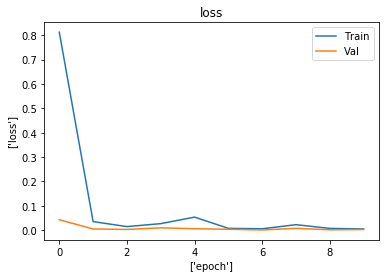

In [19]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss')
plt.xlabel(['epoch'])
plt.ylabel(['loss'])
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

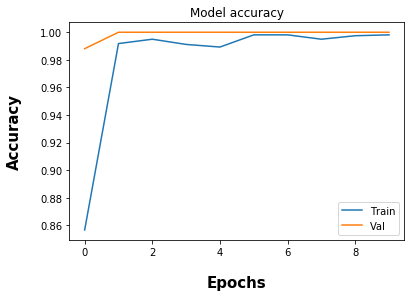

In [20]:
import matplotlib.pyplot as plt
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy',fontsize=15, fontweight='bold', labelpad=18)
plt.xlabel('Epochs',fontsize=15, fontweight='bold', labelpad=18)
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()



In [21]:
prediction=m.predict(np.array([x_test[1]]))
result=np.argmax(prediction[0])

if(result==0):
    print('business')
if(result==1):
    print('entertainment')
if(result==2):
    print('politics')
if(result==3):
    print('sports')
if(result==4):
    print('tech')

politics


In [21]:
a=str(input())
b=word_tokenize(a.lower())
fv=model.infer_vector(b)

p=m.predict(np.array([fv]))
result=np.argmax(p[0])

if(result==0):
    print('business')
if(result==1):
    print('entertainment')
if(result==2):
    print('politics')
if(result==3):
    print('sports')
if(result==4):
    print('tech')

Sachin Scored a tremendous century today
sports


In [32]:
print(np.array(x_train).shape)
print(train_x.shape)

(1668, 100)
(1668,)


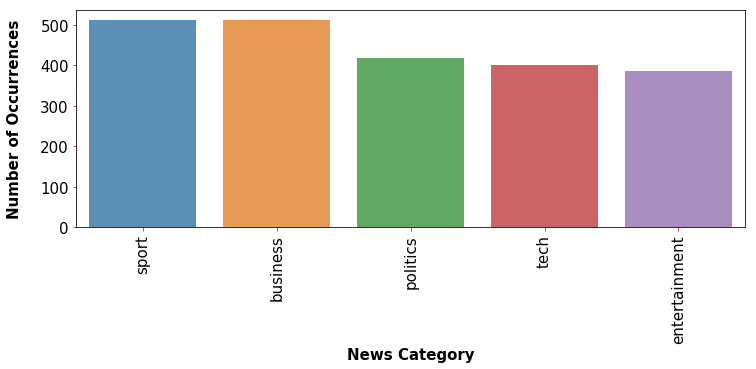

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

cnt_pro = df['category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.tick_params(color='r',labelsize=15)
plt.ylabel('Number of Occurrences', fontsize=15, labelpad=18, fontweight='bold')
plt.xlabel('News Category', fontsize=15, fontweight='bold')
plt.xticks(rotation=90)
plt.show();